# ResNet Feature Extraction
https://algorithmia.com/algorithms/imageclassification/ResNetFeatureExtraction/docs

Overview

> This algorithm can be used to gather pre-trained ResNet[1] representations of arbitrary images. This is a standard feature extraction technique that can be used in many vision applications.

Applicable Scenarios and Problems:

> Imagine you want to train an image classifier, but you want to go with a linear model instead of a neural network. However, linear models like SVM often fail to learn from raw image data. A common thing to do in such cases is to create a feature vector from raw image, which provides a low-dimensional and noise-resistant way to represent these images. One common feature extraction technique is to feed the image to a conventional pre-trained neural network, and use the representation for that particular image in the intermediate layers of the neural network. To this end, our algorithm extracts representation of given images at the penultimate layer on ResNet models pre-trained on ImageNet[2] dataset.

In [1]:
import cv2
import pandas as pd
import numpy as np
import os
from pathlib import Path
from keras.applications.densenet import preprocess_input, DenseNet121

In [2]:
def resize_to_square(im):
    old_size = im.shape[:2] # old_size is in (height, width) format
    ratio = float(img_size)/max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])
    # new_size should be in (width, height) format
    im = cv2.resize(im, (new_size[1], new_size[0]))
    delta_w = img_size - new_size[1]
    delta_h = img_size - new_size[0]
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)
    color = [0, 0, 0]
    new_im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT,value=color)
    return new_im

def load_image(pet_id):
    path = f'{Path(os.getcwd()).parents[0]}\\data\\train_images\\'
    image = cv2.imread(f'{path}{pet_id}-1.jpg')
    new_image = resize_to_square(image)
    new_image = preprocess_input(new_image)
    return new_image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


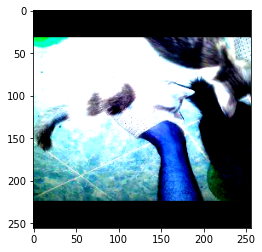

In [3]:
img_size = 256
pet_id = '4ccb3f896'
im = load_image(pet_id)

%matplotlib inline
import matplotlib.pyplot as plt
plt.imshow(im)
plt.show()

In [4]:
train = pd.read_csv("../data/train/train.csv")
pet_ids = train['PetID'].values[0:30]
img_size = 256
# batch_size = 16
# n_batches = len(pet_ids) // batch_size + 1

import time as time
start = time.time()
for b in range(len(pet_ids)):
    if b%10 == 0: 
        print(b)
    batch_images = np.zeros((len(pet_ids),img_size,img_size,3))
    for i,pet_id in enumerate(pet_ids):
        try:
            batch_images[i] = load_image(pet_id)
        except:
            pass
end = time.time()
print(end-start)

0
10
20
7.438011646270752


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


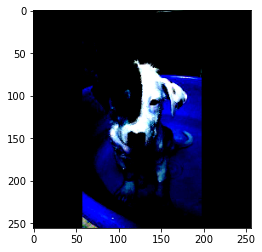

In [5]:
plt.imshow(batch_images[10])
plt.show()

In [6]:
from keras.models import Model
from keras.layers import GlobalAveragePooling2D, Input, Lambda, AveragePooling1D
import keras.backend as K
inp = Input((256,256,3))
backbone = DenseNet121(input_tensor = inp, include_top = False)
x = backbone.output
x = GlobalAveragePooling2D()(x)
x = Lambda(lambda x: K.expand_dims(x,axis = -1))(x)
x = AveragePooling1D(4)(x)
out = Lambda(lambda x: x[:,:,0])(x)

m = Model(inp,out)

In [10]:
from keras.models import Model
from keras.layers import GlobalAveragePooling2D, Input, Lambda, AveragePooling1D
import keras.backend as K

In [7]:
inp = Input((256, 256, 3))
backbone = DenseNet121(include_top=False, input_tensor=inp)
x = backbone.output
x = GlobalAveragePooling2D()(x)
x = Lambda(lambda x: K.expand_dims(x,axis = -1))(x)
x = AveragePooling1D(4)(x)
out = Lambda(lambda x: x[:,:,0])(x)

m = Model(inp,out)

In [8]:
features = {}
batch_preds = m.predict(batch_images)
for i,pet_id in enumerate(pet_ids):
    features[pet_id] = batch_preds[i]

In [9]:
train_feats = pd.DataFrame.from_dict(features, orient='index')
train_feats.columns = ['img_feat_'+str(i) for i in range(train_feats.shape[1])]
train_feats

,img_feat_0,img_feat_1,img_feat_2,img_feat_3,img_feat_4,img_feat_5,img_feat_6,img_feat_7,img_feat_8,img_feat_9,...,img_feat_246,img_feat_247,img_feat_248,img_feat_249,img_feat_250,img_feat_251,img_feat_252,img_feat_253,img_feat_254,img_feat_255
86e1089a3,0.001992,0.168180,0.019656,0.015818,0.068883,0.002202,0.005087,0.004857,0.052085,0.047539,...,0.792694,0.172717,0.570122,1.072495,0.433185,0.523335,1.536424,0.829849,0.594541,0.768361
6296e909a,0.002851,0.104892,0.019813,0.023129,0.173533,0.002304,0.005013,0.006305,0.086663,0.050197,...,0.652857,0.691035,0.561940,0.955430,1.064425,1.550079,0.907248,0.845503,0.451082,0.920725
3422e4906,0.002741,0.074317,0.024019,0.018122,0.154712,0.001939,0.004252,0.001577,0.101034,0.040034,...,0.579916,0.567165,1.126998,0.718295,1.513211,0.871183,1.327923,1.180393,0.475881,0.902964
5842f1ff5,0.002093,0.275488,0.055401,0.013913,0.092458,0.001637,0.005605,0.004332,0.121620,0.035158,...,1.288095,0.324930,0.290479,1.618020,1.114354,1.438730,0.597711,0.830946,0.486973,1.143235
850a43f90,0.002178,0.174535,0.044690,0.016134,0.170294,0.002081,0.004427,0.004161,0.100905,0.034762,...,1.086286,0.692626,0.388115,0.901950,1.224688,1.047785,1.061467,0.312212,0.426200,0.680118
d24c30b4b,0.002275,0.046672,0.038209,0.009840,0.172741,0.003570,0.004063,0.004441,0.051949,0.044583,...,0.813563,0.396371,0.752756,1.373031,0.479285,0.533578,1.849010,0.737494,1.468104,0.732137
1caa6fcdb,0.002504,0.161198,0.030618,0.013486,0.070742,0.002602,0.004763,0.007300,0.050893,0.049667,...,1.652910,0.122991,1.127001,0.711852,0.518424,0.454950,1.418870,0.521722,0.525379,0.960490
97aa9eeac,0.002221,0.060314,0.022848,0.016965,0.117748,0.002595,0.006509,0.002974,0.115134,0.043560,...,1.259343,0.216703,0.885824,1.197540,1.404676,2.114382,0.615616,0.348045,0.821584,1.235697
c06d167ca,0.002321,0.369357,0.065316,0.023613,0.075231,0.002161,0.006458,0.007310,0.067974,0.042254,...,0.364208,0.545568,0.349189,0.756056,1.048394,0.467798,1.600677,0.564019,0.373387,0.837430
7a0942d61,0.002035,0.159950,0.054382,0.010503,0.162203,0.002084,0.007149,0.004221,0.075014,0.034865,...,0.701078,0.268013,0.738264,0.958957,0.353308,0.513821,1.390245,1.441147,1.033483,1.034805


In [12]:
train = pd.read_csv("../data/train/train.csv")
pet_ids = train['PetID']
img_size = 256
batch_size = 16
n_batches = len(pet_ids) // batch_size + 1

features = {}

import time as time
start = time.time()

for b in range(n_batches):
    if b%10 == 0: 
        print(f'Processing Batch #{b}')
    start = b*batch_size
    end = (b+1)*batch_size
    batch_pets = pet_ids[start:end]
    batch_images = np.zeros((len(batch_images),img_size,img_size,3))
    for i,pet_id in enumerate(batch_pets):
        try:
            batch_images[i] = load_image(pet_id)
        except:
            pass
    batch_preds = m.predict(batch_images)
    for i,pet_id in enumerate(batch_pets):
        features[pet_id] = batch_preds[i]
                            
end = time.time()
print(f'Total Time Elapsed: {end-start}')

Processing Batch #0
Processing Batch #10
Processing Batch #20
Processing Batch #30
Processing Batch #40
Processing Batch #50
Processing Batch #60
Processing Batch #70
Processing Batch #80
Processing Batch #90
Processing Batch #100
Processing Batch #110
Processing Batch #120
Processing Batch #130
Processing Batch #140
Processing Batch #150
Processing Batch #160
Processing Batch #170
Processing Batch #180
Processing Batch #190
Processing Batch #200
Processing Batch #210
Processing Batch #220
Processing Batch #230
Processing Batch #240
Processing Batch #250
Processing Batch #260
Processing Batch #270
Processing Batch #280
Processing Batch #290
Processing Batch #300
Processing Batch #310
Processing Batch #320
Processing Batch #330
Processing Batch #340
Processing Batch #350
Processing Batch #360
Processing Batch #370
Processing Batch #380
Processing Batch #390
Processing Batch #400
Processing Batch #410
Processing Batch #420
Processing Batch #430
Processing Batch #440
Processing Batch #450

In [13]:
train_feats = pd.DataFrame.from_dict(features, orient='index')
train_feats.columns = ['pic_'+str(i) for i in range(train_feats.shape[1])]

In [21]:
train_feats['PetID'] = train_feats.index
print(train_feats.shape)
train_feats.head()

(14993, 257)


,pic_0,pic_1,pic_2,pic_3,pic_4,pic_5,pic_6,pic_7,pic_8,pic_9,...,pic_247,pic_248,pic_249,pic_250,pic_251,pic_252,pic_253,pic_254,pic_255,PetID
86e1089a3,0.001992,0.168180,0.019656,0.015818,0.068883,0.002202,0.005087,0.004857,0.052085,0.047539,...,0.172717,0.570122,1.072495,0.433185,0.523335,1.536424,0.829849,0.594541,0.768361,86e1089a3
6296e909a,0.002851,0.104892,0.019813,0.023129,0.173533,0.002304,0.005013,0.006305,0.086663,0.050197,...,0.691035,0.561940,0.955430,1.064425,1.550079,0.907248,0.845503,0.451082,0.920725,6296e909a
3422e4906,0.002741,0.074317,0.024019,0.018122,0.154712,0.001939,0.004252,0.001577,0.101034,0.040034,...,0.567165,1.126998,0.718295,1.513211,0.871183,1.327923,1.180393,0.475881,0.902964,3422e4906
5842f1ff5,0.002093,0.275488,0.055401,0.013913,0.092458,0.001637,0.005605,0.004332,0.121620,0.035158,...,0.324930,0.290479,1.618020,1.114354,1.438730,0.597711,0.830946,0.486973,1.143235,5842f1ff5
850a43f90,0.002178,0.174535,0.044690,0.016134,0.170294,0.002081,0.004427,0.004161,0.100905,0.034762,...,0.692626,0.388115,0.901950,1.224688,1.047785,1.061467,0.312212,0.426200,0.680118,850a43f90


In [22]:
train_feats.to_csv("train_processed.csv")

In [24]:
def load__image(pet_id):
    path = f'{Path(os.getcwd()).parents[0]}\\data\\test_images\\'
    image = cv2.imread(f'{path}{pet_id}-1.jpg')
    new_image = resize_to_square(image)
    new_image = preprocess_input(new_image)
    return new_image

In [25]:
test = pd.read_csv("../data/test/test.csv")
pet_ids = test['PetID']
img_size = 256
batch_size = 16
n_batches = len(pet_ids) // batch_size + 1

features = {}

import time as time
start = time.time()

for b in range(n_batches):
    if b%10 == 0: 
        print(f'Processing Batch #{b}')
    start = b*batch_size
    end = (b+1)*batch_size
    batch_pets = pet_ids[start:end]
    batch_images = np.zeros((len(batch_images),img_size,img_size,3))
    for i,pet_id in enumerate(batch_pets):
        try:
            batch_images[i] = load_image(pet_id)
        except:
            pass
    batch_preds = m.predict(batch_images)
    for i,pet_id in enumerate(batch_pets):
        features[pet_id] = batch_preds[i]
                            
end = time.time()
print(f'Total Time Elapsed: {end-start}')

Processing Batch #0
Processing Batch #10
Processing Batch #20
Processing Batch #30
Processing Batch #40
Processing Batch #50
Processing Batch #60
Processing Batch #70
Processing Batch #80
Processing Batch #90
Processing Batch #100
Processing Batch #110
Processing Batch #120
Processing Batch #130
Processing Batch #140
Processing Batch #150
Processing Batch #160
Processing Batch #170
Processing Batch #180
Processing Batch #190
Processing Batch #200
Processing Batch #210
Processing Batch #220
Processing Batch #230
Processing Batch #240
Total Time Elapsed: 1613810642.1288133


In [26]:
test_feats = pd.DataFrame.from_dict(features, orient='index')
test_feats.columns = ['pic_'+str(i) for i in range(test_feats.shape[1])]
test_feats['PetID'] = test_feats.index
print(test_feats.shape)
test_feats.head()

(3972, 257)


,pic_0,pic_1,pic_2,pic_3,pic_4,pic_5,pic_6,pic_7,pic_8,pic_9,...,pic_247,pic_248,pic_249,pic_250,pic_251,pic_252,pic_253,pic_254,pic_255,PetID
e2dfc2935,0.001913,0.200123,0.034662,0.011279,0.22124,0.002751,0.001853,0.004002,0.114433,0.029524,...,0.004894,0.045289,0.03007,0.013002,0.045237,0.051465,0.071165,0.063994,0.055685,e2dfc2935
f153b465f,0.001913,0.200123,0.034662,0.011279,0.22124,0.002751,0.001853,0.004002,0.114433,0.029524,...,0.004894,0.045289,0.03007,0.013002,0.045237,0.051465,0.071165,0.063994,0.055685,f153b465f
3c90f3f54,0.001913,0.200123,0.034662,0.011279,0.22124,0.002751,0.001853,0.004002,0.114433,0.029524,...,0.004894,0.045289,0.03007,0.013002,0.045237,0.051465,0.071165,0.063994,0.055685,3c90f3f54
e02abc8a3,0.001913,0.200123,0.034662,0.011279,0.22124,0.002751,0.001853,0.004002,0.114433,0.029524,...,0.004894,0.045289,0.03007,0.013002,0.045237,0.051465,0.071165,0.063994,0.055685,e02abc8a3
09f0df7d1,0.001913,0.200123,0.034662,0.011279,0.22124,0.002751,0.001853,0.004002,0.114433,0.029524,...,0.004894,0.045289,0.03007,0.013002,0.045237,0.051465,0.071165,0.063994,0.055685,09f0df7d1


In [28]:
test_feats.to_csv("test_processed.csv")